# Train and Tune all Models for Comparison

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.config import Config
from src.runners import run_experiment
from src.utils import set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
rng = set_seed(cfg.runtime.seed)

2025-08-23 20:22:19,925 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = pd.read_csv(Path(cfg.data.processed_dir) / cfg.data.name_features_full)
df_full

,date,open,high,low,close,volume,adj_close,pos,neu,neg,...,target_30,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,quarter,dow
0,2008-08-19,11478.089844,11478.169922,11318.500000,11348.549805,171580000,11348.549805,0.042369,0.942838,0.014793,...,-0.001807,-0.015602,0.003778,0.007168,-0.009451,-0.011943,0.004085,NaN,3,1
1,2008-08-20,11345.940430,11454.150391,11290.580078,11417.429688,144880000,11417.429688,0.043197,0.772239,0.184564,...,-0.032678,-0.011463,-0.015602,0.003778,0.007168,-0.009451,-0.011943,0.004085,3,2
2,2008-08-21,11415.230469,11476.209961,11315.570312,11430.209961,130020000,11430.209961,0.001049,0.777835,0.221116,...,-0.015136,0.006051,-0.011463,-0.015602,0.003778,0.007168,-0.009451,-0.011943,3,3
3,2008-08-22,11426.790039,11632.129883,11426.790039,11628.059570,138790000,11628.059570,0.100609,0.738009,0.161382,...,-0.036480,0.001119,0.006051,-0.011463,-0.015602,0.003778,0.007168,-0.009451,3,4
4,2008-08-25,11626.190430,11626.269531,11362.629883,11386.250000,148610000,11386.250000,0.003025,0.902580,0.094395,...,-0.052416,0.017161,0.001119,0.006051,-0.011463,-0.015602,0.003778,0.007168,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,0.065429,0.684537,0.250034,...,NaN,-0.034473,0.012866,-0.002746,0.001395,0.007312,-0.003273,0.005254,2,0
1978,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,0.086932,0.714076,0.198991,...,NaN,-0.015084,-0.034473,0.012866,-0.002746,0.001395,0.007312,-0.003273,2,1
1979,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,0.114712,0.673349,0.211939,...,NaN,0.015600,-0.015084,-0.034473,0.012866,-0.002746,0.001395,0.007312,2,2
1980,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,0.040575,0.727080,0.232345,...,NaN,0.016235,0.015600,-0.015084,-0.034473,0.012866,-0.002746,0.001395,2,3


In [4]:
EXPERIMENTS = [
    ("linreg", True),
    ("xgboost", True)
]
H = 30
results = []

for kind, include_sent in EXPERIMENTS:
    res = run_experiment(
        kind=kind,
        df_full=df_full,
        include_sentiment=include_sent,
        out_dir=str(Path(cfg.data.processed_dir)),
        forecast_horizon=H,
        random_state=cfg.runtime.seed,
        n_trials=30
    )
    results.append(res)

2025-08-23 20:22:20,024 - INFO - ModelTrainer - Initialized ModelTrainer for model: linreg_h30
[I 2025-08-23 20:22:20,025] A new study created in memory with name: linreg_with_sent_h30
2025-08-23 20:22:20,025 - INFO - ModelTrainer - Starting model tuning...
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e+00, tolerance: 3.910e-02
  model = cd_fast.enet_coordinate_descent(
[I 2025-08-23 20:22:20,345] Trial 0 finished with value: 0.010132885964950848 and parameters: {'alpha': 0.0001329291894316216, 'l1_ratio': 0.9507143064099162, 'max_iter': 3500, 'selection': 'cyclic'}. Best is trial 0 with value: 0.010132885964950848.
2025-08-23 20:22:20,346 - INFO - ModelTrainer - Starting model tuning...
D:\IntelliJ\ml-stock-sent\.venv\Lib\site-packages\sklearn\l

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

H = 30                                            # your forecast horizon
FIGDIR = Path(cfg.data.fig_dir)                   # where to save figures

df_plot = df_full.copy()
df_plot["date"] = pd.to_datetime(df_plot["date"], errors="coerce").dt.tz_localize(None)

# use the first model as reference for indices (all models share the same split)
ref = results[0]
test_index = ref["test_index"]
anchor_idx  = int(test_index[-1])                 # last observed test row
anchor_date = pd.to_datetime(df_plot.loc[anchor_idx, "date"])
p0          = float(df_plot.loc[anchor_idx, "adj_close"])

# future window & actuals (for the anchored 30-day comparison)
future      = df_plot.iloc[anchor_idx + 1 : anchor_idx + 1 + H].copy()
fut_dates   = pd.to_datetime(future["date"]).to_numpy()
actual_path = future["adj_close"].to_numpy(float)

# short history for context plots
hist = df_plot.iloc[max(0, anchor_idx - 200 + 1) : anchor_idx + 1]

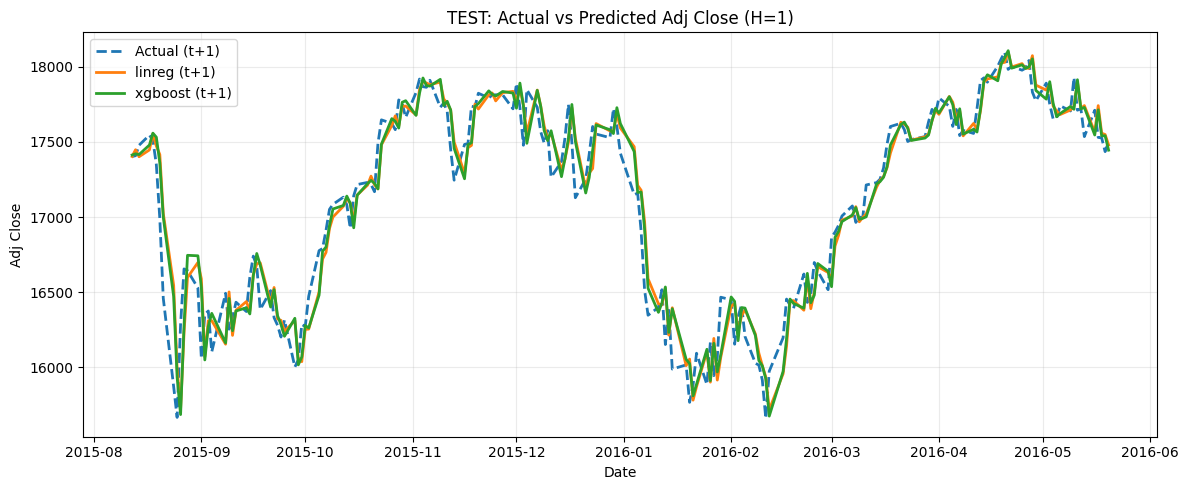

In [6]:
# ===== TEST overlay (H=1) =====
idx0 = test_index.to_numpy()
valid = idx0 + 1 < len(df_plot)
idx0, idx1 = idx0[valid], (idx0 + 1)[valid]

dates_test  = df_plot.loc[idx1, "date"].to_numpy()
actual_next = df_plot.loc[idx1, "adj_close"].to_numpy(float)
p_t         = df_plot.loc[idx0, "adj_close"].to_numpy(float)

plt.figure(figsize=(12, 5))
plt.plot(dates_test, actual_next, "--", label="Actual (t+1)", linewidth=2)

for res in results:
    ypred = np.asarray(res["y_pred_test"])
    lr1   = ypred[valid, 0] if (ypred.ndim == 2 and ypred.shape[1] >= 1) else ypred[valid]
    pred_next = p_t * np.exp(lr1)
    plt.plot(dates_test, pred_next, label=f"{res['kind']} (t+1)", linewidth=2)

plt.title("TEST: Actual vs Predicted Adj Close (H=1)")
plt.xlabel("Date"); plt.ylabel("Adj Close")
plt.grid(True, alpha=0.25); plt.legend(); plt.tight_layout()
FIGDIR.mkdir(parents=True, exist_ok=True)
# plt.savefig(FIGDIR / "TEST_overlay_h1_all_models.png", dpi=150)
plt.show()
plt.close()


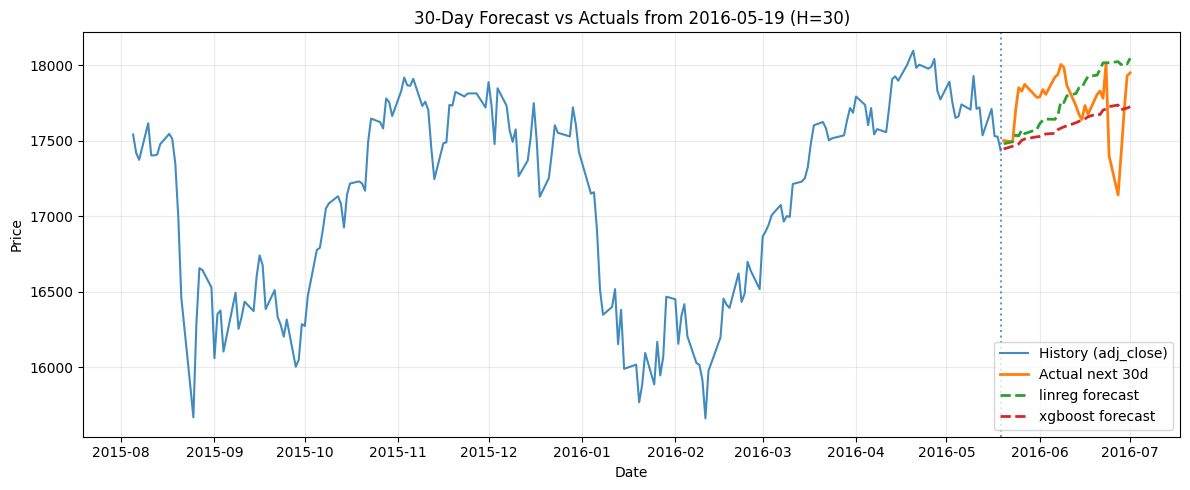

In [7]:
# ===== 30-day overlay (anchored at last TEST row) =====
plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(hist["date"]), hist["adj_close"], label="History (adj_close)", alpha=0.85)
plt.axvline(anchor_date, linestyle=":", alpha=0.7)
plt.plot(fut_dates, actual_path, label=f"Actual next {H}d", linewidth=2)

# predicted price path per model from its H log-returns at anchor
price_paths = {}
for res in results:
    lr_path = np.asarray(res["y_pred_last"]).ravel()[:H]
    price_paths[res["kind"]] = p0 * np.exp(np.cumsum(lr_path))
    plt.plot(fut_dates, price_paths[res["kind"]], "--", linewidth=2, label=f"{res['kind']} forecast")

plt.title(f"30-Day Forecast vs Actuals from {anchor_date.date()} (H={H})")
plt.xlabel("Date"); plt.ylabel("Price")
plt.grid(True, alpha=0.25); plt.legend(); plt.tight_layout()
# plt.savefig(FIGDIR / "forecast_30d_all_models.png", dpi=150)
plt.show()
plt.close()


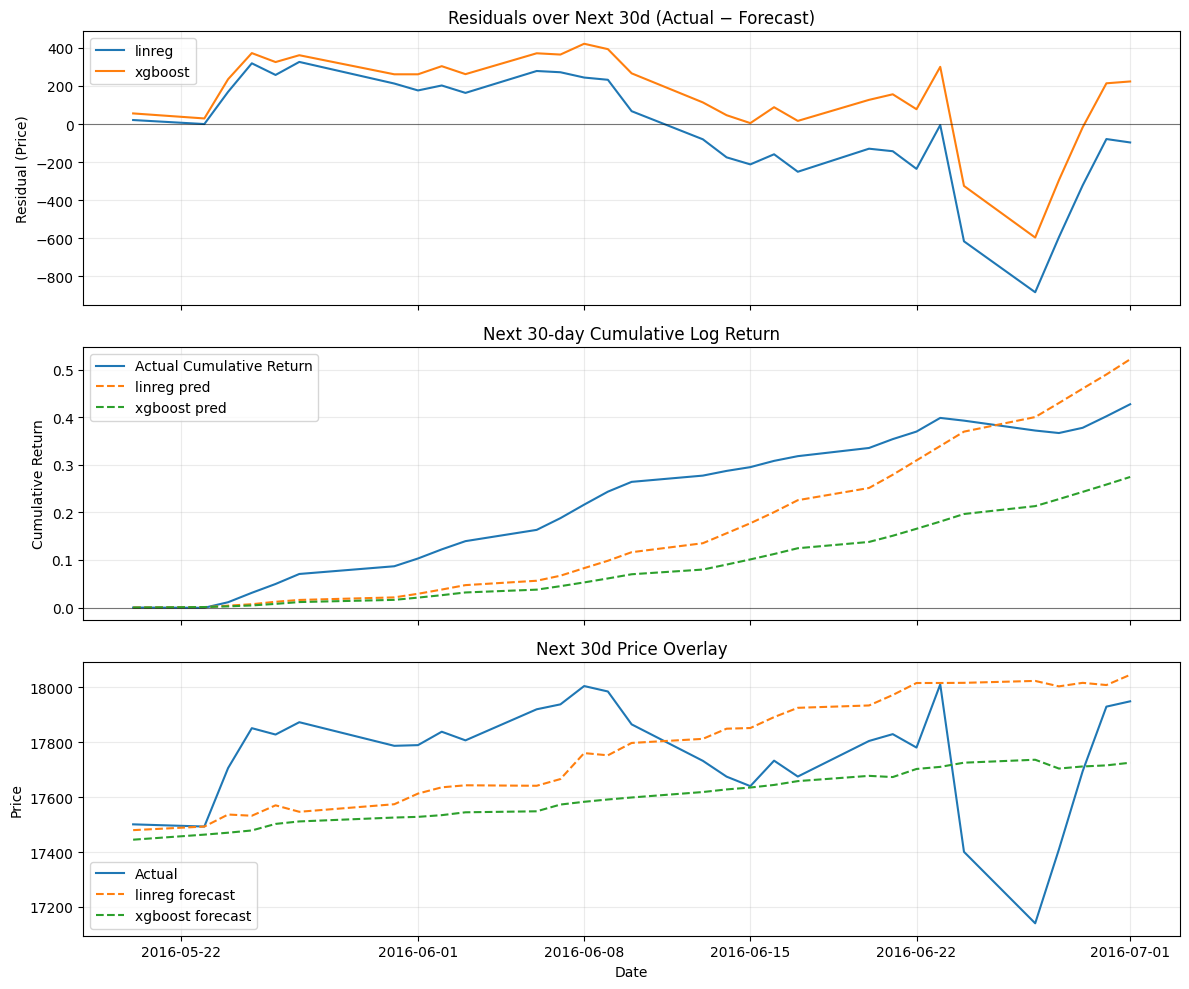

In [8]:
# ===== Diagnostics (residuals, cumulative log return, price overlay) =====
fig, (ax_res, ax_clr, ax_pr) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# residuals: Actual - Forecast
for kind, path in price_paths.items():
    ax_res.plot(fut_dates, actual_path - path, label=kind)
ax_res.axhline(0, color="k", linewidth=0.8, alpha=0.5)
ax_res.set_title("Residuals over Next 30d (Actual − Forecast)")
ax_res.set_ylabel("Residual (Price)")
ax_res.grid(True, alpha=0.25)
ax_res.legend()

# cumulative LOG return relative to anchor price p0: log(P_t / P0)# --- cumulative LOG return (matching your reference) ---
# baseline is the first future point, not the anchor p0
ax_clr.clear()

actual_cum = np.cumsum(np.log(actual_path.astype(float) / float(actual_path[0])))
ax_clr.plot(fut_dates, actual_cum, label="Actual Cumulative Return")

for kind, path in price_paths.items():
    path = np.asarray(path, dtype=float)
    pred_cum = np.cumsum(np.log(path / float(path[0])))
    ax_clr.plot(fut_dates, pred_cum, "--", label=f"{kind} pred")

ax_clr.axhline(0, color="k", linewidth=0.8, alpha=0.5)
ax_clr.set_title("Next 30-day Cumulative Log Return")
ax_clr.set_ylabel("Cumulative Return")
ax_clr.grid(True, alpha=0.25)
ax_clr.legend()

# horizon-only price overlay
ax_pr.plot(fut_dates, actual_path, label="Actual")
for kind, path in price_paths.items():
    ax_pr.plot(fut_dates, path, "--", label=f"{kind} forecast")
ax_pr.set_title("Next 30d Price Overlay")
ax_pr.set_xlabel("Date"); ax_pr.set_ylabel("Price")
ax_pr.grid(True, alpha=0.25)
ax_pr.legend()

fig.tight_layout()
# plt.savefig(FIGDIR / "forecast_30d_diagnostics_all_models.png", dpi=150)
plt.show()
plt.close()
